<a href="https://colab.research.google.com/github/omartinez182/data-science-notebooks/blob/master/Marketing_Mix_Modeling_Data_Science_in_Marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Marketing Mix Modeling
### Data Science in Marketing

Omar Eduardo Martinez\
https://www.linkedin.com/in/omarmartinez182/ \
https://twitter.com/omarmartinez182

Este "notebook" tiene como objetivo demostrar las aplicaciones de "Data Science" en Marketing, presentando un caso de uso especifico y desarrollando un proyecto completo, pasando por varias etapas de un tipico proyecto de machine learning (ML).

**Objetivo del proyecto:** Entender el impacto en las conversiones de un sitio web en base a los diferentes canales digitales que comprenden el [Marketing Mix](https://en.wikipedia.org/wiki/Marketing_mix) de un sitio web.


---


### El proyecto se divide en las siguientes 3 etapas:

1.   Data Prep & EDA
2.   Modeling
3.   Interpretabilidad e importancia de las variables


## Etapa 1: Data preparation & Exploratory Data Analysis (EDA)

### Load and prep data

In [ ]:
#Librerias para cargar, visualizar, y manipular datos
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
plt.style.use('seaborn')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Luego de cargar las librerias y modulos necesarios para el proyecto, el siguiente paso naturalmente es cargar el dataset con el cual estaremos trabajando. 

Para esto, usaremos la funcion de pandas para leer archivos planos.

In [ ]:
url = 'https://raw.githubusercontent.com/omartinez182/Python-scripts/master/Marketing_Mix_Dataset.csv'
data = pd.read_csv(url) # Dataset ahora se encuentra en un dataframe
data.tail()

,Date,Goal_Completions,Organic,Generic_Paid_Search,Direct,Display,Paid_Search,Social,Referral
733,7/28/20,985,4124,3739,2762,2692,116,407,309
734,7/29/20,1064,3947,3042,3018,3115,259,261,476
735,7/30/20,1081,3895,2991,5667,3137,91,557,427
736,7/31/20,892,4178,1908,2111,2221,555,355,339
737,8/1/20,517,2273,2744,747,1625,73,75,193


Utilizando el metodo ".tail" podemos ver las ultimas 5 observaciones en el dataframe. A primera vista, todo parece funcionar de manera apropiada, sin embargo, al cargar fechas utilizando un archivo plano, es necesario hacer el cambio al tipo de dato fecha. Para esto tambien utilizamos pandas, haciendo la conversion con la funcion "to_datetime". 

In [ ]:
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%y') #Convertimos el formato de la columna de fecha (Date)
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738 entries, 0 to 737
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 738 non-null    datetime64[ns]
 1   Goal_Completions     738 non-null    int64         
 2   Organic              738 non-null    int64         
 3   Generic_Paid_Search  738 non-null    int64         
 4   Direct               738 non-null    int64         
 5   Display              738 non-null    int64         
 6   Paid_Search          738 non-null    int64         
 7   Social               738 non-null    int64         
 8   Referral             738 non-null    int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 52.0 KB


Con el metodo ".info()" podemos obtener un "summary" del dataset, en donde se especifica cuantas observaciones (filas) tiene cada variable (columnas) y el tipo de dato.

### EDA

Para empezar a entender el comportamiento de las variables independientes y su relacion con la variable dependiente, generaremos una matriz de correlacion que utilice un heatmap representando la intensidad de correlacion entre las variables.

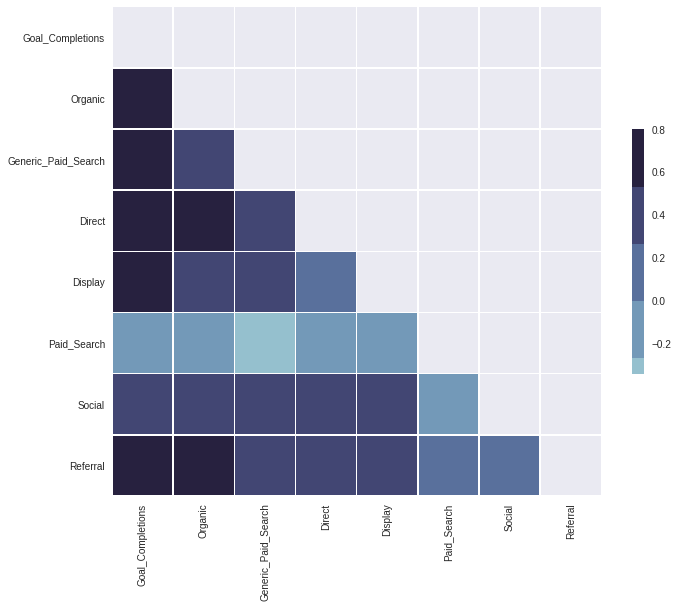

In [ ]:
# Matriz de correlacion
corr = data[['Goal_Completions', 'Organic', 'Generic_Paid_Search', 'Direct',
       'Display', 'Paid_Search', 'Social', 'Referral']].corr()

# Generar mascara para el triangulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configurar la figura de matplotlib 
f, ax = plt.subplots(figsize=(11, 9))

# Generar un mapa de color custom 
cmap = sns.color_palette("ch:start=.2,rot=-.3")

# Dibujar el heatmap con las mascara y el aspect ratio correctos 
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Al parecer, el canal "Paid_Search" es el que tiene una menor correlacion con todas las otras varaibles, incluyendo la variable dependiente. Sin embargo, es necesario considerar que la correlacion no nos dara "insights" especificos de relaciones no lineales. 

Para poder entender la distribucion de cada variable y potencialmente identificar outliers, podemos generar un funcion que nos ayude a generar "plots" de la distribucion de cada variable y que la compare con una distribucion normal teorica.

In [ ]:
def diag_normal_var(df, variable):
  plt.figure(figsize=(15,6))
  plt.subplot(1, 2, 1)
  df[variable].hist(bins=30)

  plt.subplot(1, 2, 2)
  stats.probplot(df[variable], dist='norm', plot = plt)
  plt.title(variable)
  plt.show()

Ahora, solo necesitamos indicar cuales son las variables que deseamos visualizar.

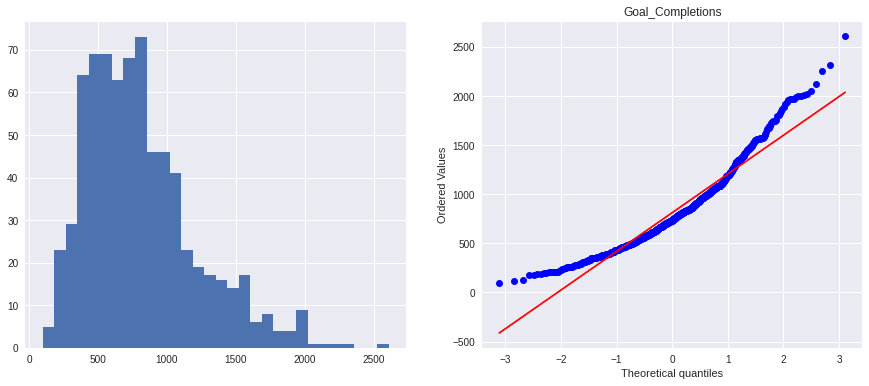

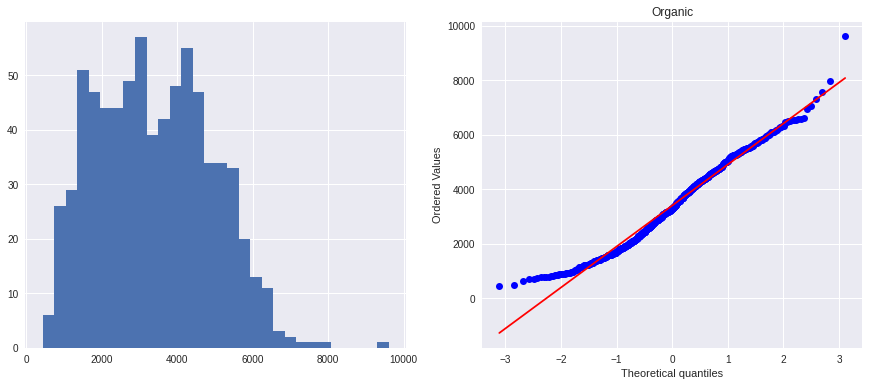

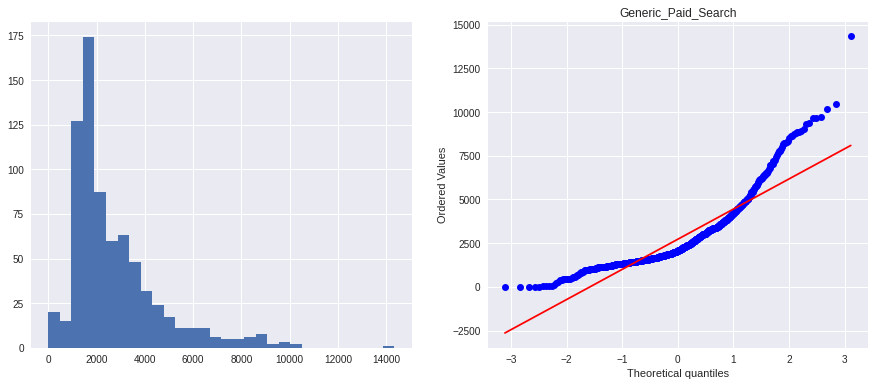

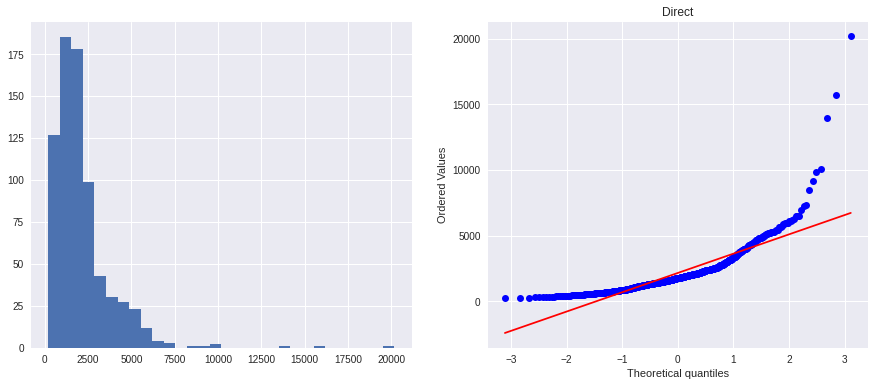

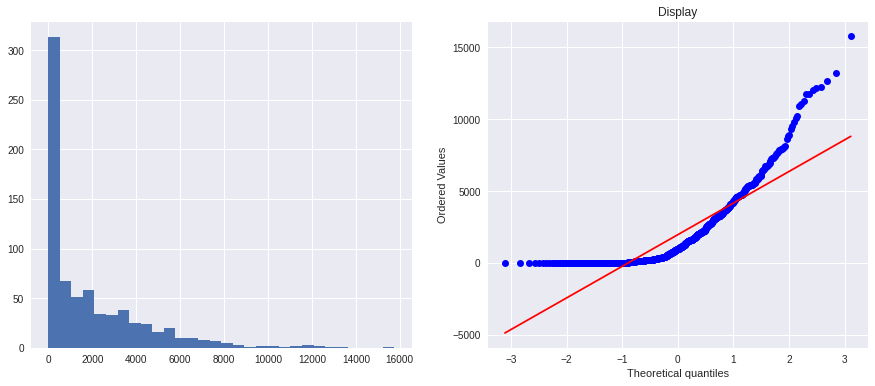

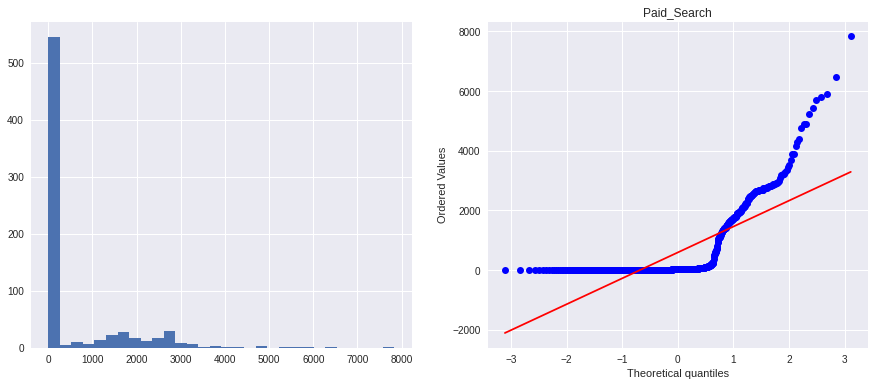

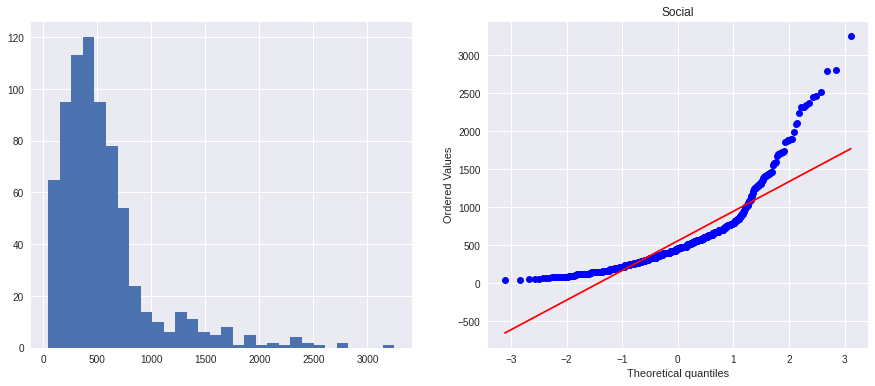

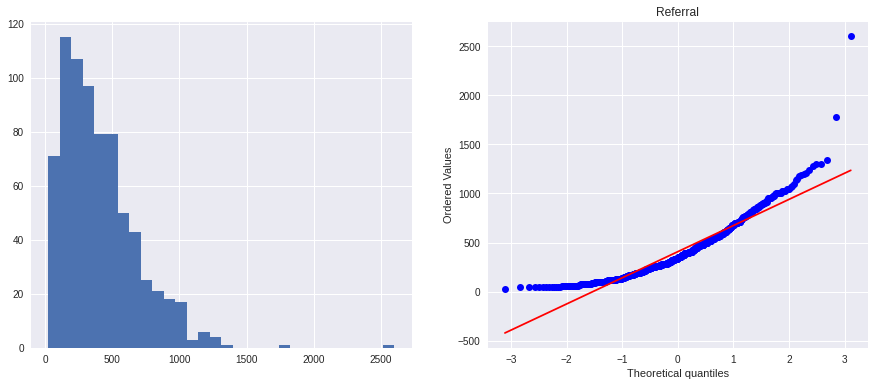

In [ ]:
numerical_features = ['Goal_Completions', 'Organic', 'Generic_Paid_Search', 'Direct',
       'Display', 'Paid_Search', 'Social', 'Referral']
                      
# "Plots" de la distribucion de cada variable numerical
for i in numerical_features:
  diag_normal_var(data, i)

Ciertas variables cuentan con outliers, en este caso usaremos el metodo de  "[winsorization](https://en.wikipedia.org/wiki/Winsorizing)" para manejar esas observaciones especificas.

In [ ]:
!pip install feature_engine

In [ ]:
from feature_engine import outlier_removers as outr
columns = data.columns

# Configuramos el  capper
capper = outr.Winsorizer(distribution='skewed', tail='right', fold=3, variables=numerical_features)

# fit del capper
capper.fit(data)

# transformacion de la data
data = capper.transform(data)

capper.right_tail_caps_

{'Direct': 6590.5,
 'Display': 12004.25,
 'Generic_Paid_Search': 9035.0,
 'Goal_Completions': 2516.5,
 'Organic': 11811.25,
 'Paid_Search': 2383.0,
 'Referral': 1625.25,
 'Social': 1841.25}

Por ultimo, podemos hacer un simple plot y fitting de una trendline a diferentes variables para obtener una idea o un "assessment" inicial del modelo que podemos construir.

In [ ]:
import plotly.express as px

#Creamos un plot entre la variable dependiente y alguna variable independiente
df = data
fig = px.scatter(df, x="Goal_Completions", y="Organic", trendline="ols", color_discrete_sequence=px.colors.qualitative.G10_r)
fig.show()

## Etapa 2: Modeling

Con un dataset en condiciones optimas para modelaje, podemos continuar con la etapa de contruir nuestro Marketing Mix Model. Empezamos por cargar los modulos/librerias necesarios para construir nuestro modelo.

In [ ]:
#Instalar scikit optimize
!pip install scikit-optimize

In [ ]:
#Instalar SHAP
!pip install shap

In [ ]:
#Modelos + Cross-validation
from sklearn.model_selection import KFold
import xgboost as xgb

#Plotting
import matplotlib.pylab as plt
%matplotlib inline

#Optimizacion
import skopt
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

#Feature importances
import shap

#Remove warnings of sliced dataframes
import warnings
warnings.filterwarnings("ignore")

# load JS visualization code to notebook
shap.initjs()

Para poder entrenar a nuestro modelo, debemos de separar la variable dependiente (**y**) o tambien conocida como "target", de las variables predictoras (**X**). 

En este caso, nuestro "target" es la variable "Goal_Completions" que representa la cantidad de personas que completaron la accion deseada en el sitio web. Las variables predictoras, son la cantidad de usuarios obtenidos a traves de los diferentes canales de adquisición digitales. 

In [ ]:
#Separamos la variable independiente de los predictores
X = data.drop(['Goal_Completions','Date'], axis=1)
y = data['Goal_Completions']

In [ ]:
X.shape

(738, 7)

Con el metodo ".shape" podemos ver el tamaño de nuestro dataset, notar que trabajaremos con 738 observaciones(filas) y 7 variables (columnas).

Ahora utilizaremos el algoritmo XGBoost para generar un modelo de regresion. Ademas, utilizarmos un proceso de optimizacion para ajustar los parametros del algoritmo y encontrar la combinacion optima.

In [ ]:
#Semilla
seed = 42

#Creamos el objeto regresor
xgbst = xgb.XGBRegressor(objective ='reg:squarederror', random_state=42)

#Grid de Hyperparametros
xgbst_param_grid = {'learning_rate': Real(0.01, 1.0, 'log-uniform'),
                    'max_depth': Integer(0, 50),
                    'colsample_bytree': Real(0.01, 1.0, 'uniform') ,
                    'n_estimators' : Integer(50, 800)
                   }

cv10 = KFold(n_splits=10, shuffle=True, random_state = seed)

# Usamos 50 iteraciones con "Bayesian Optimization" para encontrar los mejores parametros para nuestro modelo y lo evaluamos con 10-fold cross-validation.
xgbst_opt = BayesSearchCV(xgbst,
                          xgbst_param_grid,
                          scoring='neg_mean_squared_error',
                          n_iter=50,
                          cv=cv10,          
                          n_jobs=1,
                          return_train_score=False,
                          refit=True,
                          optimizer_kwargs={'base_estimator': 'GP'},
                          random_state = seed, verbose=0)

xgbst_opt.fit(X, y)

In [ ]:
RMSE = np.sqrt(np.absolute(xgbst_opt.best_score_))
print("RMSE :", round(RMSE,4))

RMSE : 128.6055


In [ ]:
xgbst_opt.best_estimator_

In [ ]:
#Generamos modelo final para utilizar con SHAP
model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.8142720284737898, 
                       learning_rate = 0.022066991249460103, max_depth = 30, n_estimators = 652).fit(X, y)

## Etapa 3: Interpretabilidad e importancia de las variables

Si bien es importante entender la capacidad de nuestro modelo para hacer predicciones, recordemos que nuestro objetivo principal es entender la contribucion a las conversiones en terminos generales de cada una de las variables. 

Para esto utilizaremos un procedimiento, poco convencional, prestando ideas y metodologias tanto de "Machine Learning" como de "Teoria de Juegos". 

Luego de generar nuestro modelo, podemos utilizar la libraria [SHAP](https://github.com/slundberg/shap) para calcular [Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html) y consecuentemente medir la importancia de cada variable en el resultado de las predicciones del modelo.

In [ ]:
# Explicamos las predicciones del modelo utilizando el "TreeExplainer" de la libreria SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [ ]:
#JS visualization
shap.initjs()

# Visualizamos las interacciones para la primer prediccion
shap.force_plot(explainer.expected_value, shap_values[291,:], X.iloc[291,:])

La grafica de arriba, llamada "Force Plot", nos indica como los valores especificos de cada variable, contribuyen al valor de la prediccion. En este caso, el "Force Plot" nos permite entender las predicciones a nivel local, es decir, a nivel de cada observacion.  

El "base value" (valor base o valor esperado) es el promedio del output del modelo utilizando los datos de entrenamiento.

In [ ]:
#JS visualization
shap.initjs()

# Visualizar un set de predicciones 
shap.force_plot(explainer.expected_value, shap_values, X)

Ademas, tambien podemos ver el impacto general de cada variable en nuestro modelo.

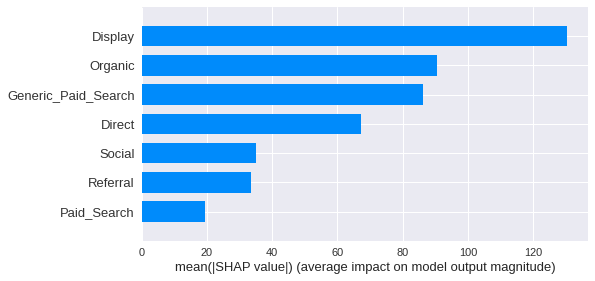

In [ ]:
#Visualizamos en general el impacto (magnitud) de cada variable
shap.summary_plot(shap_values, X, plot_type="bar")

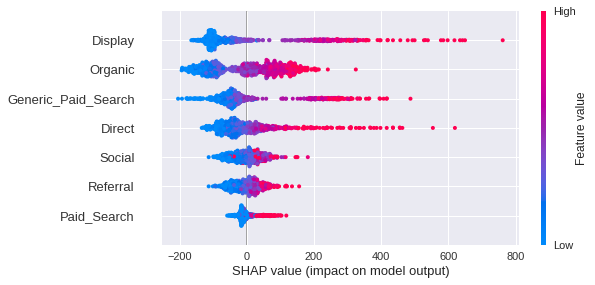

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

Por ultimo, podemos visualizar especificamente las variables de interes para entender mejor su comportamiento y el impacto que tienen en las predicciones.

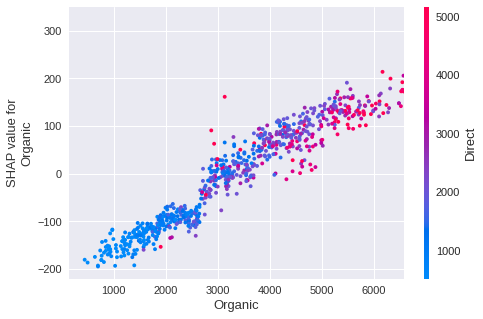

In [ ]:
#Creamos un "dependence plot" para mostrar el efecto de una sola variable en todo el dataset
shap.dependence_plot("Organic", shap_values, X, xmax="percentile(99)",
                     dot_size=15, interaction_index='Direct')

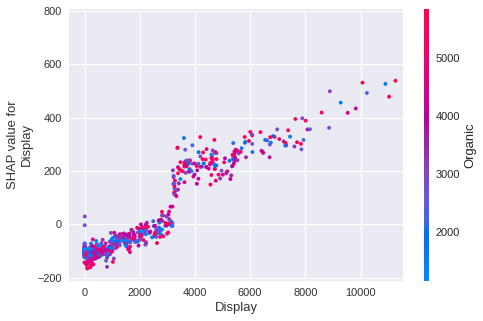

In [ ]:
#Creamos un "dependence plot" para mostrar el efecto de una sola variable en todo el dataset
shap.dependence_plot("Display", shap_values, X, xmax="percentile(99)",
                     dot_size=15, interaction_index='Organic')

# The end!